# Depth image estimation from RGB data.

This is a baseline notebook to estimate depth from RGB images using a basic UNET architecture, taken from [keras-unet](https://pypi.org/project/keras-unet-collection/) library, and L2 loss.

The model is trained using the preprocessed sample (03543) available in the starter kit. The first 200 frames used for training, and the next 50 for validation and the last 50 for test sets. The data directory structure follows:

--- root
> --- image
>> --- \<sample\>_\<frame number\>.jpg

> --- depth
>> --- \<sample\>_\<frame number\>.npy

NOTE: the RGB and depth images have not been cropped. They have a shape of (640, 480). The UNET in this baseline works in the original resolution. However, this makes the training slow. You'd better to use smaller resolutions by the help of cropping. In this case you can also increase the batch size.



## Install UNET library

In [1]:
!pip install keras-unet-collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.4 MB/s eta 0:00:00


## Mount google drive and import libraries

In [2]:
# Download and unzip the data
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras_unet_collection import models
from keras_unet_collection.utils import dummy_loader
import numpy as np
import cv2
import gc
import random
import pickle

## We implement a data generator class to load the data in batches

DataGenerator is initialized by several input variables:
- **data_list** which is a list of video names for either training, validation or test sets,
- **root** is the root path to the target set (i.e. training, validation or test),
- **batch_size** is the batch size,
- **shuffle** is indicating whether shuffling the data list or not.

NOTE 1: we perform a normalization on the image and depth images. The per image normalization is a subtraction of the mean followed by a division by standard deviation. The depth normalization is a subtraction of the minimum depth (plus a small margin to differentiate from the background) divided by a fixed scaler. The scaler is used to ensure the depth range is [0..1]. We assume the possible maximum depth is 2 meters and use it as the scaler. Also we apply a fixed scaler to be able to easily reconstruct the real depth at inference time.

NOTE 2: in this notebook we do not use the depth scaler at inference time nor computing the metrics. You must note that the measured metrics won't be comparable if you do not reconstruct the depth back to its original space. For instance, by changing the scaler value the range of predicted depth values will be different.

NOTE 3: depth normalization is applied on the foreground values. The background remains zero.


In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_list, root, batch_size=16, shuffle=True):
        super().__init__()
        'Initialization'
        self.data_list = data_list
        self.root = root
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Find list of IDs
        data_list_temp = self.getdatalist(index)

        # Generate data
        X, y = self.__data_generation(data_list_temp)
        
        return X, y

    def getdatalist(self, index):
        'Get the list of data for one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        data_list_batch = [self.data_list[k] for k in indexes]

        return data_list_batch

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, data_list):
      'Generates data containing batch_size samples'
      X_img, Y_depth = [], []
      for f in data_list:
        # Load depth image
        dpt = np.load(open(self.root+'/depth/'+f+'.npy', 'rb'))
        mask = dpt>0
        # Normalize depth image
        min = dpt[mask].min()
        mean = dpt[mask].mean()
        max = dpt[mask].max()
        dpt[mask] = (dpt[mask] - min + 0.001) / 2.0
        Y_depth.append(dpt)

        # Read RGB image
        img = cv2.imread(self.root+'/image/'+f+'.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        # Normalize RGB image
        r_mean, g_mean, b_mean = [img[:, :, 0][mask].mean(), img[:, :, 1][mask].mean(), img[:, :, 2][mask].mean()]
        r_std, g_std, b_std = [img[:, :, 0][mask].std(), img[:, :, 1][mask].std(), img[:, :, 2][mask].std()]
        img[:, :, 0][mask] = (img[:, :, 0][mask] - r_mean) / (r_std + 0.0001)
        img[:, :, 1][mask] = (img[:, :, 1][mask] - g_mean) / (g_std + 0.0001)
        img[:, :, 2][mask] = (img[:, :, 2][mask] - b_mean) / (b_std + 0.0001)
        X_img.append(img)

      return np.array(X_img, np.float32), np.array(Y_depth, np.float32)

## Build the network

You can check [here](https://github.com/yingkaisha/keras-unet-collection/blob/main/examples/user_guide_models.ipynb) for the UNET configurations.

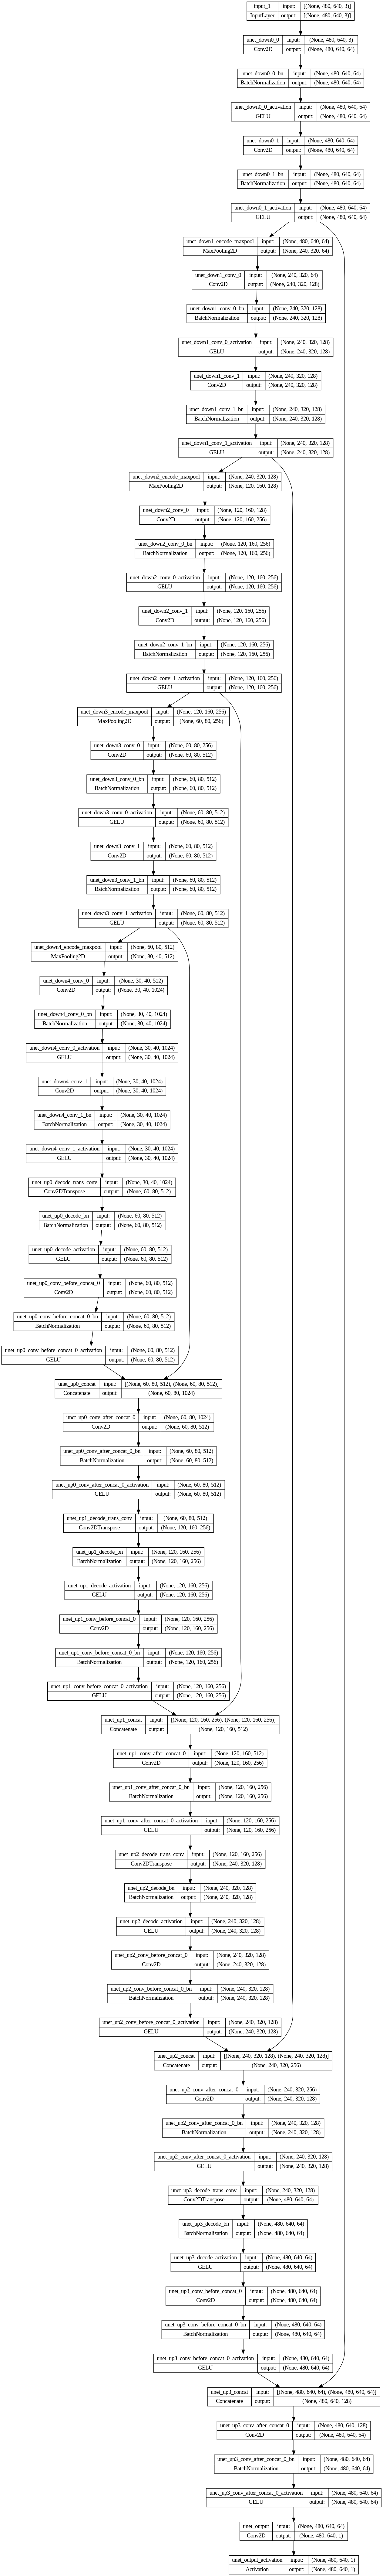

In [5]:
# Create model
model = models.unet_2d((480, 640, 3), [64, 128, 256, 512, 1024], n_labels=1,
                      stack_num_down=2, stack_num_up=1,
                      activation='GELU', output_activation='Sigmoid', 
                      batch_norm=True, pool='max', unpool=False, name='unet')

tf.keras.utils.plot_model(model, show_shapes=True)

## Read the list of train, validation and test files

In [6]:
# Read the data lists
root = '/gdrive/MyDrive/cloth3d/data/'

with open(root+'train.txt', 'r') as f:
  train_list = f.readlines()
  for i in range(len(train_list)):
    train_list[i] = train_list[i].rsplit('\n',1)[0]

with open(root+'validation.txt', 'r') as f:
  validation_list = f.readlines()
  for i in range(len(validation_list)):
    validation_list[i] = validation_list[i].rsplit('\n',1)[0]

with open(root+'test.txt', 'r') as f:
  test_list = f.readlines()
  for i in range(len(test_list)):
    test_list[i] = test_list[i].rsplit('\n',1)[0]

## Training and evaluation

The model is trained with adam optimizer with a learning rate of 0.001 and mean square error (L2) loss function. The batch size is 2 and the model is trained for 10 epochs. Also a callback is defined to save the best trained model by monitoring mean absolute error on the validation set. Finally the history log is saved in the defined path and model is evaluated on the test set.

In [10]:
# hyperparameters
lr = 1e-3
batch_size = 2
n_epochs = 10
checkpoint = './best_model.h5'
shuffle = True
verbose = 1

In [11]:
# Training

# creating data generators to load the data
train_dg = DataGenerator(train_list, root, batch_size=batch_size, shuffle=shuffle)
validation_dg = DataGenerator(validation_list, root, batch_size=batch_size, shuffle=False)

# defining the optimizer
model.compile(tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

# saving the best model based on val_loss
mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True)

# training the model and saving the history
history = model.fit(train_dg, validation_data=validation_dg, epochs=n_epochs, verbose=verbose, callbacks=[mc,es])

with open('./train_history.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/10
100/100 [==============================] - 155s 1s/step - loss: 0.0714 - mae: 0.2149 - val_loss: 0.0516 - val_mae: 0.2107
Epoch 2/10
100/100 [==============================] - 107s 1s/step - loss: 0.0108 - mae: 0.0692 - val_loss: 0.5026 - val_mae: 0.5599
Epoch 3/10
100/100 [==============================] - 107s 1s/step - loss: 0.0024 - mae: 0.0322 - val_loss: 0.8973 - val_mae: 0.9096
Epoch 4/10
100/100 [==============================] - 109s 1s/step - loss: 0.0013 - mae: 0.0259 - val_loss: 8.5647e-04 - val_mae: 0.0251
Epoch 5/10
100/100 [==============================] - 109s 1s/step - loss: 9.0709e-04 - mae: 0.0210 - val_loss: 6.2778e-04 - val_mae: 0.0134
Epoch 6/10
100/100 [==============================] - 111s 1s/step - loss: 5.0333e-04 - mae: 0.0155 - val_loss: 2.9627e-04 - val_mae: 0.0116
Epoch 7/10
100/100 [==============================] - 109s 1s/step - loss: 3.9064e-04 - mae: 0.0137 - val_loss: 2.3009e-04 - val_mae: 0.0096
Epoch 8/10
100/100 [=====================

In [13]:
# Evaluate the trained model on the test set

test_dg = DataGenerator(test_list, root, batch_size=1, shuffle=False)

model.load_weights(checkpoint)

print('Evaluating on the test set')

_mae = 0
for step in range(test_dg.__len__()):
  # Load the batch
  X, Y = test_dg.__getitem__(step)
  
  # validate on one batch
  prediction = model.predict(tf.convert_to_tensor(X, dtype=tf.float32), verbose=0)
  
  # Note that in the evaluation the background is ignored
  # Therefore the MAE on the test set is not comparable with the train/validation
  _mae += np.abs(prediction[Y!=0] - Y[Y!=0]).mean()

  # Some house keeping
  gc.collect()
  tf.keras.backend.clear_session()

print("The final mean absolute error is {0:.3f}\n".format(_mae/(step+1)))

Evaluating on the test set
The final mean absolute error is 0.047



## Visualizing the history: train and validation loss and MAE for each epoch

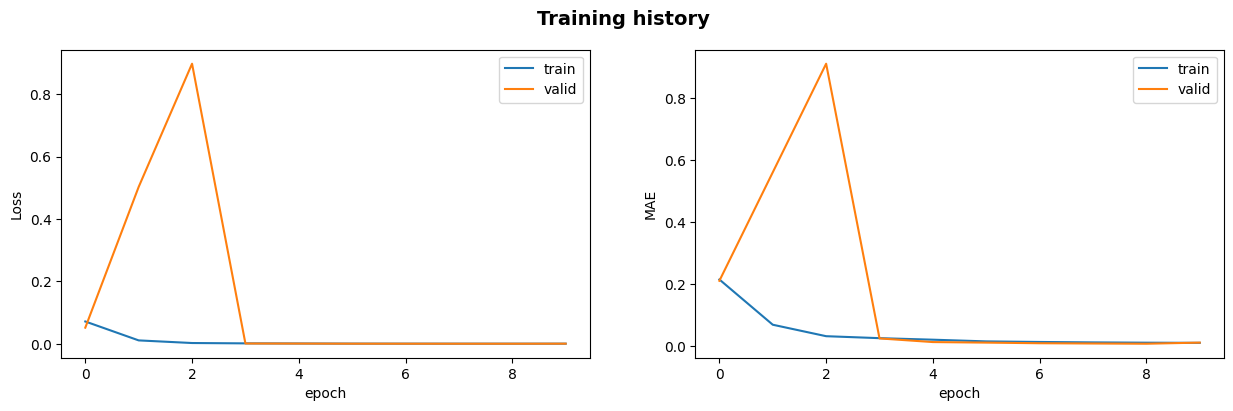

In [15]:
# Visualization
import pickle
from matplotlib import pyplot as plt

train_hist = pickle.load(open('./train_history.pkl',"rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

## Visualize the prediction for a sample

Visualization of the predictions on the first sample of the test set


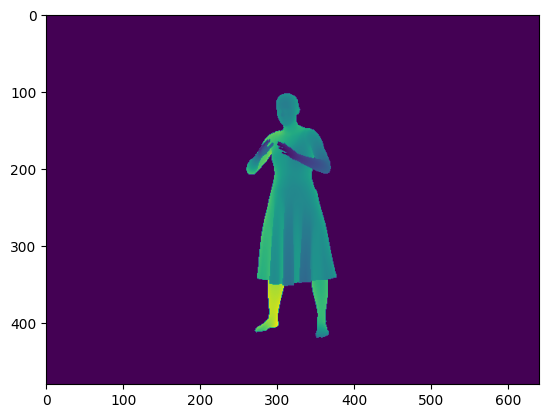

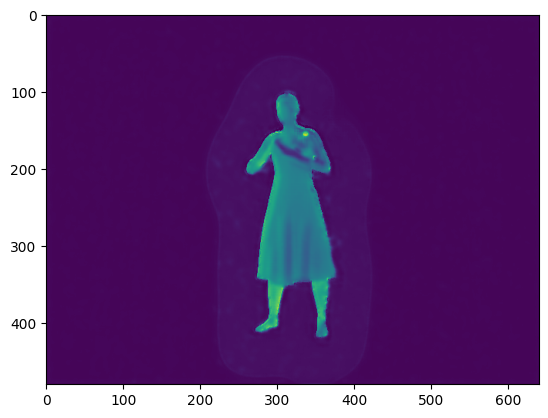

In [14]:
import numpy as np
import pickle
from matplotlib import pyplot as plt

print('Visualization of the predictions on the first sample of the test set')

# Load the batch
step = 0
X, Y = test_dg.__getitem__(step)
  
# validate on one batch
prediction = model.predict(tf.convert_to_tensor(X, dtype=tf.float32), verbose=0)

# Some house keeping
gc.collect()
tf.keras.backend.clear_session()

# Visualize an example prediction
plt.imshow(Y[0])
plt.show()
plt.imshow(prediction[0])
plt.show()